In [ ]:
# ============================
# Imports
# ============================
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
from statistics import mean
# NLP
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob

# Models / ML utils
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.metrics import (
    classification_report, accuracy_score, confusion_matrix,
    precision_score, recall_score, f1_score, balanced_accuracy_score, make_scorer
)
from sklearn.base import clone


from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score, precision_score, recall_score,
    f1_score, classification_report, confusion_matrix, make_scorer
)
from sklearn.base import clone
from statistics import mean

# Repro
np.random.seed(42)

# ============================
# NLTK resources
# ============================
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('vader_lexicon')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [ ]:
# importing files into the Colab
from google.colab import files
uploaded=files.upload()

Saving upload_DJIA_table.csv to upload_DJIA_table.csv


In [ ]:
# load news and stock dataset
df=pd.read_csv("Combined_News_DJIA.csv")
dj=pd.read_csv("upload_DJIA_table.csv")

In [ ]:
# Combine news headlines as one column
#ech row has one text, representing all news for that day

df["combined news"]=df.loc[:,"Top1":"Top25"].astype(str).agg(" ".join,axis=1)

In [ ]:
#cleaning the text column
# Convert text to lowercase and remove unwanted characters, links, and punctuation

stop = set(stopwords.words("english"))   #Load a list of common English stopwords
lemmatizer = WordNetLemmatizer()   #Load a lemmatizer, which reduces words to their root form

def clean_text(text):
    text = re.sub(r"b[\"']", " ", str(text).lower())
    text = re.sub(r"\[.*?\]\(.*?\)", "", text)
    text = re.sub(r"[^\w\s]", " ", text)  ## remove punctuation
    text = re.sub(r"\s+", " ", text)  # remove extra whitespace
    tokens = word_tokenize(text)    # tokenize into words (Tokenize each headline into individual words)
    output = [lemmatizer.lemmatize(word) for word in tokens if word.isalpha() and word not in stop] # Lemmatize words to reduce them to their base form
    return " ".join(output)

# we apply a clean_text function to every row in the combined news
df["clean text"]=df["combined news"].apply(clean_text)

In [ ]:
# Sentiment Analysis using TextBlob
# Define a function to get polarity and subjectivity
# Polarity: measures how positive or negative the text is (-1 to 1).
# Subjectivity: measures how subjective or objective the text is (0 to 1).
# Returns both polarity and subjectivity for each news entry.

def get_sentiment(text):
    analysis = TextBlob(text)
    return analysis.sentiment.polarity, analysis.sentiment.subjectivity

In [ ]:

# ======================================
# Apply sentiment analysis and classify sentiment
# ======================================
# Use the get_sentiment function to compute polarity and subjectivity for each cleaned news text
# Store the results in two new columns: "Polarity" and "Subjectivity"



#  Apply the function to the "clean text" column and create two new columns
df[["Polarity", "Subjectivity"]] = df["clean text"].apply(
    lambda x: pd.Series(get_sentiment(x))
)

# Define a simple rule to classify sentiment based on polarity:
#       Polarity > 0  → Positive
#       Polarity < 0  → Negative
#       Polarity = 0  → Neutral


# Define a function to classify sentiment based on polarity
def classify_sentiment(polarity):
    if polarity > 0:
        return "Positive"
    elif polarity < 0:
        return "Negative"
    else:
        return "Neutral"

# Create a new column "Sentiment_Label" to store these sentiment categories
# Apply sentiment classification
df["Sentiment_Label"] = df["Polarity"].apply(classify_sentiment)

# Print the first few rows to verify results
# View result
print(df[["clean text", "Polarity", "Subjectivity", "Sentiment_Label"]].head())


                                          clean text  Polarity  Subjectivity  \
0  georgia down two russian warplane country move... -0.047536      0.254960   
1  wont america nato help u wont help u help iraq...  0.113565      0.346443   
2  remember adorable year old sang opening ceremo... -0.026211      0.506694   
3  u refuse israel weapon attack iran report pres...  0.014531      0.335034   
4  expert admit legalise drug war south osetia pi...  0.037480      0.344004   

  Sentiment_Label  
0        Negative  
1        Positive  
2        Negative  
3        Positive  
4        Positive  


In [ ]:
df.head()

,Date,Label,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,...,Top21,Top22,Top23,Top24,Top25,combined news,clean text,Polarity,Subjectivity,Sentiment_Label
0,2008-08-08,0,"b""Georgia 'downs two Russian warplanes' as cou...",b'BREAKING: Musharraf to be impeached.',b'Russia Today: Columns of troops roll into So...,b'Russian tanks are moving towards the capital...,"b""Afghan children raped with 'impunity,' U.N. ...",b'150 Russian tanks have entered South Ossetia...,"b""Breaking: Georgia invades South Ossetia, Rus...","b""The 'enemy combatent' trials are nothing but...",...,b'Why the Pentagon Thinks Attacking Iran is a ...,b'Caucasus in crisis: Georgia invades South Os...,b'Indian shoe manufactory - And again in a se...,b'Visitors Suffering from Mental Illnesses Ban...,"b""No Help for Mexico's Kidnapping Surge""","b""Georgia 'downs two Russian warplanes' as cou...",georgia down two russian warplane country move...,-0.047536,0.254960,Negative
1,2008-08-11,1,b'Why wont America and Nato help us? If they w...,b'Bush puts foot down on Georgian conflict',"b""Jewish Georgian minister: Thanks to Israeli ...",b'Georgian army flees in disarray as Russians ...,"b""Olympic opening ceremony fireworks 'faked'""",b'What were the Mossad with fraudulent New Zea...,b'Russia angered by Israeli military sale to G...,b'An American citizen living in S.Ossetia blam...,...,b'Israeli Physicians Group Condemns State Tort...,b' Russia has just beaten the United States ov...,b'Perhaps *the* question about the Georgia - R...,b'Russia is so much better at war',"b""So this is what it's come to: trading sex fo...",b'Why wont America and Nato help us? If they w...,wont america nato help u wont help u help iraq...,0.113565,0.346443,Positive
2,2008-08-12,0,b'Remember that adorable 9-year-old who sang a...,"b""Russia 'ends Georgia operation'""","b'""If we had no sexual harassment we would hav...","b""Al-Qa'eda is losing support in Iraq because ...",b'Ceasefire in Georgia: Putin Outmaneuvers the...,b'Why Microsoft and Intel tried to kill the XO...,b'Stratfor: The Russo-Georgian War and the Bal...,"b""I'm Trying to Get a Sense of This Whole Geor...",...,b'War in Georgia: The Israeli connection',b'All signs point to the US encouraging Georgi...,b'Christopher King argues that the US and NATO...,b'America: The New Mexico?',"b""BBC NEWS | Asia-Pacific | Extinction 'by man...",b'Remember that adorable 9-year-old who sang a...,remember adorable year old sang opening ceremo...,-0.026211,0.506694,Negative
3,2008-08-13,0,b' U.S. refuses Israel weapons to attack Iran:...,"b""When the president ordered to attack Tskhinv...",b' Israel clears troops who killed Reuters cam...,b'Britain\'s policy of being tough on drugs is...,b'Body of 14 year old found in trunk; Latest (...,b'China has moved 10 *million* quake survivors...,"b""Bush announces Operation Get All Up In Russi...",b'Russian forces sink Georgian ships ',...,b'Gorbachev: We Had No Choice',b'Witness: Russian forces head towards Tbilisi...,b' Quarter of Russians blame U.S. for conflict...,b'Georgian president says US military will ta...,b'2006: Nobel laureate Aleksander Solzhenitsyn...,b' U.S. refuses Israel weapons to attack Iran:...,u refuse israel weapon attack iran report pres...,0.014531,0.335034,Positive
4,2008-08-14,1,b'All the experts admit that we should legalis...,b'War in South Osetia - 89 pictures made by a ...,b'Swedish wrestler Ara Abrahamian throws away ...,b'Russia exaggerated the death toll in South O...,b'Missile That Killed 9 Inside Pakistan May Ha...,"b""Rushdie Condemns Random House's Refusal to P...",b'Poland and US agree to missle defense deal. ...,"b'Will the Russians conquer Tblisi? Bet on it,...",...,b'Saudi Arabia: Mother moves to block child ma...,b'Taliban wages war on humanitarian aid workers',"b'Russia: World ""can forget about"" Georgia\'s...",b'Darfur rebels accuse Sudan of mounting major...,b'Philippines : Peace Advocate say Muslims nee...,b'All the experts admit that we should legalis...,expert ad

In [ ]:
# summary of the number of rows for each sentiment
df["Sentiment_Label"].value_counts()

,count
Sentiment_Label,
Positive,1203
Negative,786


In [ ]:
df.columns

Index(['Date', 'Label', 'Top1', 'Top2', 'Top3', 'Top4', 'Top5', 'Top6', 'Top7',
       'Top8', 'Top9', 'Top10', 'Top11', 'Top12', 'Top13', 'Top14', 'Top15',
       'Top16', 'Top17', 'Top18', 'Top19', 'Top20', 'Top21', 'Top22', 'Top23',
       'Top24', 'Top25', 'combined news', 'clean text', 'Polarity',
       'Subjectivity', 'Sentiment_Label'],
      dtype='object')

In [ ]:
df=df[['Date', 'Label', 'clean text', 'Polarity',
       'Subjectivity', 'Sentiment_Label']]

In [ ]:
df.head()

,Date,Label,clean text,Polarity,Subjectivity,Sentiment_Label
0,2008-08-08,0,georgia down two russian warplane country move...,-0.047536,0.254960,Negative
1,2008-08-11,1,wont america nato help u wont help u help iraq...,0.113565,0.346443,Positive
2,2008-08-12,0,remember adorable year old sang opening ceremo...,-0.026211,0.506694,Negative
3,2008-08-13,0,u refuse israel weapon attack iran report pres...,0.014531,0.335034,Positive
4,2008-08-14,1,expert admit legalise drug war south osetia pi...,0.037480,0.344004,Positive


In [ ]:
dj.head()

,Date,Open,High,Low,Close,Volume,Adj Close
0,2016-07-01,17924.240234,18002.380859,17916.910156,17949.369141,82160000,17949.369141
1,2016-06-30,17712.759766,17930.609375,17711.800781,17929.990234,133030000,17929.990234
2,2016-06-29,17456.019531,17704.509766,17456.019531,17694.679688,106380000,17694.679688
3,2016-06-28,17190.509766,17409.720703,17190.509766,17409.720703,112190000,17409.720703
4,2016-06-27,17355.210938,17355.210938,17063.080078,17140.240234,138740000,17140.240234


In [ ]:
#merge the news dataset and stock price dataset
df_merged=pd.merge(df,dj,on="Date",how="inner")

In [ ]:
df=df_merged.copy()

In [ ]:

# Convert and sort dates
# Convert the "Date" column to proper datetime format to ensure consistent date handling
# Use 'errors="coerce"' to handle any invalid date entries by setting them as NaT.
# Sort the dataframe by date in ascending order and reset the index for proper sequential order.


df["Date"]  = pd.to_datetime(df["Date"], errors="coerce")   # Convert the Date column in the sentiment data to proper datetime format
df= df.sort_values("Date").reset_index(drop=True)

In [ ]:
df.columns

Index(['Date', 'Label', 'clean text', 'Polarity', 'Subjectivity',
       'Sentiment_Label', 'Open', 'High', 'Low', 'Close', 'Volume',
       'Adj Close'],
      dtype='object')

In [ ]:
df.columns

Index(['Date', 'Label', 'clean text', 'Polarity', 'Subjectivity',
       'Sentiment_Label', 'Open', 'High', 'Low', 'Close', 'Volume',
       'Adj Close'],
      dtype='object')

#Classification
**horizon=  1 day**

In [ ]:
# ======================================
# parameters
# ======================================
RND          = 42
np.random.seed(RND)
SPLIT_DATE   = pd.Timestamp("2015-01-01")  # the boundary between training data (< 2015) and testing data (≥ 2015).
N_SPLITS     = 5                           # number of folds used in time-series cross-validation
HORIZON_DAYS = 1                           # prediction horizon (1-day ahead)
K_OPTIONS    = [8, 12, 16, 20, 30, 40]     # candidate values for k in k-NN or dimensionality settings in other models
THR_GRID     = np.linspace(0.2, 0.8, 61)   # a sequence of classification threshold values to search for optimal decision boundary

In [ ]:
# ======================================
# Data preparation and validation
# ======================================

# Ensure "Date" is properly parsed as datetime and sort the dataset chronologically
df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
df = df.sort_values("Date").reset_index(drop=True)


# Define the essential columns required for analysis
need_cols = ['Polarity', 'Subjectivity', 'Open', 'High', 'Low',
             'Close', 'Volume', 'Adj Close']

# Check whether all required columns are present in the dataset
# If any expected columns are missing, raise an error to prevent proceeding with incomplete data
missing = [c for c in need_cols if c not in df.columns]
if missing:
    raise ValueError(f"Missing columns in price table: {missing}")

# Convert all numerical columns to numeric dtype to avoid processing errors
for c in need_cols:
    df[c] = pd.to_numeric(df[c], errors="coerce")

# Remove any rows with invalid or missing dates or value
df = df.dropna(subset=["Date", "Adj Close"]).reset_index(drop=True)

In [ ]:
# ----------------------------------------------
# Helper functions for generating technical indicators
# ----------------------------------------------


# Relative Strength Index (RSI), a momentum indicator
# it measures the speed and magnitude of price changes

def rsi(series, n=14):
    d = series.diff()
    up = d.clip(lower=0).rolling(n).mean()
    dn = (-d.clip(upper=0)).rolling(n).mean()
    rs = up / (dn + 1e-12)
    return 100 - 100/(1+rs)

# Moving Average Convergence Divergence
# it captures the relationship between fast and slow exponential moving averages
# to indicate trend direction and potential reversals.

def macd(series, fast=12, slow=26, signal=9):
    ema_f = series.ewm(span=fast, adjust=False).mean()
    ema_s = series.ewm(span=slow, adjust=False).mean()
    line = ema_f - ema_s
    sig  = line.ewm(span=signal, adjust=False).mean()
    return line, sig, line - sig

# roll_feats
# it Generates rolling statistical features over multiple window sizes,
# including moving averages, rolling standard deviations, exponential moving averages, price changes, z-scores, and quantiles
# These features enrich the model with meaningful historical price dynamics.

def roll_feats(s, wins=(3,5,10)):
    d = {"raw": s}
    for w in wins:
        d[f"mean{w}"] = s.rolling(w).mean()
        d[f"std{w}"]  = s.rolling(w).std()
        d[f"ema{w}"]  = s.ewm(span=w, adjust=False).mean()
        d[f"chg{w}"]  = s.diff(w)
    d["z20"] = (s - s.rolling(20).mean())/(s.rolling(20).std()+1e-12)
    d["q25"] = s.rolling(10).quantile(0.25)
    d["q75"] = s.rolling(10).quantile(0.75)
    return d

**Construct feature matrix with market and sentiment signals**


In [ ]:
# Convert the Adj Close column to a numeric type, coercing invalid entries to NaN for clean analysis.
px = pd.to_numeric(df["Adj Close"], errors="coerce")

In [ ]:
# Compute technical indicators:

ret1  = px.pct_change()                    # ret1, ret5, ret10: percentage price changes over 1, 5, and 10 days.
ret5  = px.pct_change(5)
ret10 = px.pct_change(10)
vol10 = ret1.rolling(10).std()             # vol10, vol20: rolling volatility measures (std of daily returns) over 10 and 20 days.
vol20 = ret1.rolling(20).std()
rsi14 = rsi(px,14)                         # rsi14: 14-day Relative Strength Index measuring overbought/oversold conditions.
macd_line, macd_sig, macd_hist = macd(px)  # MACD components: MACD line, signal line, and histogram for trend identification.

In [ ]:
# TextBlob sentiment blocks
# Extract daily sentiment metrics and generate rolling sentiment features


#  to capture temporal patterns and evolution in sentiment over time
Subjectivity = df["Subjectivity"]
Polarity     = df["Polarity"]

# roll_feats() applies rolling-window statistics
Subjectivity_d = roll_feats(Subjectivity)
Polarity_d     = roll_feats(Polarity)

In [ ]:
# Extract day-of-week and month as numeric features to capture weekly and seasonal patterns

dow   = df["Date"].dt.dayofweek.astype(float)
month = df["Date"].dt.month.astype(float)

In [ ]:
# Create a new DataFrame 'F' combining price data, returns, technical indicators, temporal features (day-of-week, month)
# we create this DataFrame F to combine all relevant features in one place
F = pd.DataFrame({
    "Date": df["Date"],
    "Open":  df["Open"],
    "High":  df["High"],
    "Low":   df["Low"],
    "Close": df["Close"],
    "Adj_Close": px,
    "Volume": df["Volume"],
    "ret1":ret1, "ret5":ret5, "ret10":ret10,
    "vol10":vol10, "vol20":vol20,
    "rsi14": rsi14,
    "macd": macd_line, "macd_signal": macd_sig, "macd_hist": macd_hist,
    "dow": dow, "month": month
})



In [ ]:
# we add the rolling sentiment features to our main DataFrame


# Define a helper function 'add_block' to add multiple related features
def add_block(prefix, dct):
    for k, v in dct.items():
        F[f"{prefix}_{k}"] = v

# Add the rolling subjectivity and polarity features from TextBlob sentiment analysis to the DataFrame
add_block("Subjectivity", Subjectivity_d)
add_block("Polarity",     Polarity_d)

In [ ]:
# Check that the prediction horizon is valid (at least 1 day) before creating the target variable

if HORIZON_DAYS < 1:
    raise ValueError("HORIZON_DAYS must be >= 1")

In [ ]:
# -----------------------------
# Create target variable for supervised learning
# -----------------------------

# Features at date t (after applying any lag) use information only up to t-1.
# This ensures we don't use future data to predict the past (avoids data leakage).

# Target at date t is defined as the cumulative return from (t-1) to (t-1 + HORIZON_DAYS):
#  px.shift(1) gives the price at t-1 (previous day)
#  px.shift(-(HORIZON_DAYS - 1)) gives the price at the end of the horizon (future)
# The formula (future_price / past_price - 1) computes the percentage change over the horizon

future_return = px.shift(-(HORIZON_DAYS - 1)) / px.shift(1) - 1.0

# Convert continuous return into a binary target:
# 1 if the future return is positive (price went up)
# 0 if the future return is zero or negative (price stayed the same or went down)
y_target = (future_return > 0).astype(int)

# Combine target values with the corresponding dates in a new DataFrame
# This makes it easy to merge with feature DataFrame for model training
target_df = pd.DataFrame({"Date": df["Date"], "y": y_target.values})


In [ ]:
# Lag all features by 1 day to ensure only past information is used for prediction


lagged = F.copy()                  # Copy the feature DataFrame F to a new DataFrame 'lagged'

for col in lagged.columns:         #Shift every column (except 'Date') by 1 row
    if col != "Date":
        lagged[col] = lagged[col].shift(1)

# Merge lagged features with the target (price up/down) for the corresponding date.
# Drop rows with NaN created by lagging to create a clean dataset for model training Shifting the first row creates NaNs since there is no prior day data
lagged = pd.merge(lagged, target_df, on="Date", how="left")
lagged = lagged.dropna().reset_index(drop=True)

# the outcome is that Each row in 'lagged' now contains only past information as input features
# and the corresponding binary target for the current date.

In [ ]:
# Train/Test split

# Split the lagged dataset into training and testing sets based on SPLIT_DATE:
# All rows before SPLIT_DATE go into 'train'.
# All rows on/after SPLIT_DATE go into 'test'
train = lagged[lagged["Date"] <  SPLIT_DATE].copy()
test  = lagged[lagged["Date"] >= SPLIT_DATE].copy()

#  If either train or test is empty (e.g., wrong SPLIT_DATE), compute a dynamic 80/20 split using the 80% index.
#    - Print a warning with the chosen fallback date.
#if len(train) == 0 or len(test) == 0:
    #dyn_split = lagged["Date"].iloc[int(len(lagged)*0.8)]
    #print(f"[WARN] Using dynamic split at {dyn_split.date()} (80/20).")
    #train = lagged[lagged["Date"] <  dyn_split].copy()
    #test  = lagged[lagged["Date"] >= dyn_split].copy()


feature_cols = [c for c in lagged.columns if c not in ["Date","y"]]
X_train = train[feature_cols].to_numpy()
y_train = train["y"].astype(int).to_numpy()
X_test  = test[feature_cols].to_numpy()
y_test  = test["y"].astype(int).to_numpy()

print(f"Train n={len(y_train)}  Test n={len(y_test)}  |  "
      f"P(up)_train={y_train.mean():.3f}  P(up)_test={y_test.mean():.3f}  "
      f"| Horizon={HORIZON_DAYS}d")

Train n=1590  Test n=378  |  P(up)_train=0.542  P(up)_test=0.508  | Horizon=1d


In [ ]:
# TimeSeriesSplit cross-validation setup with custom scorer

# Determine effective number of splits:
# N_SPLITS_EFF ensures at least 2 splits and does not exceed the number of training samples minus 1
N_SPLITS_EFF = min(N_SPLITS, max(2, len(y_train)-1))


# If the requested N_SPLITS is too large, reduce it and print an info message
if N_SPLITS_EFF < N_SPLITS:
    print(f"[INFO] Reducing CV folds from {N_SPLITS} to {N_SPLITS_EFF}.")

# Create a TimeSeriesSplit object for cross-validation
tscv = TimeSeriesSplit(n_splits=N_SPLITS_EFF)

# Create list of train/validation indices for all splits
# cv_splits contains the indices of each fold
cv_splits = list(tscv.split(X_train, y_train))

# Define a scorer using balanced accuracy
# scorer_balacc uses balanced_accuracy_score to account for class imbalance
scorer_balacc = make_scorer(balanced_accuracy_score)

**Hyperparameter Grids**

In [ ]:

# Helper function to create a pipeline with scaling, feature selection and classifier

def pipe_with_selector(est):
    return Pipeline([
        ("sc", StandardScaler()),  # Scale features to mean=0, std=1
        ("sel", SelectKBest(score_func=mutual_info_classif, k=10)),  # Select top 10 features
        ("clf", est)  # Classifier
    ])

# Logistic Regression pipeline
pipe_lr  = Pipeline([
    ("sc", StandardScaler()),  # Scale features
    ("clf", LogisticRegression(max_iter=2000,  # Maximum iterations for convergence
                               class_weight="balanced",  # Handle imbalanced classes
                               random_state=RND))
])

# Linear Discriminant Analysis pipeline
pipe_lda = Pipeline([
    ("sc", StandardScaler()),
    ("clf", LinearDiscriminantAnalysis())
])

# Random Forest classifier (no pipeline needed, can handle unscaled features)
rf = RandomForestClassifier(
    n_estimators=600,  # Number of trees
    random_state=RND,  # Reproducibility
    n_jobs=-1
)

# SVM pipeline with feature selection
pipe_svm = pipe_with_selector(SVC(
    probability=True,  # Output probabilities
    class_weight="balanced",  # Handle class imbalance
    random_state=RND
))

# KNN pipeline with feature selection
pipe_knn = pipe_with_selector(KNeighborsClassifier())

# Naive Bayes (Gaussian) classifier
nb = GaussianNB()

# Hyperparameter grids for tuning models
param_grids = {
    "KNN": {
        "est": pipe_knn,
        "grid": {
            "sel__k": K_OPTIONS,  # Number of top features to select
            "clf__n_neighbors":[3,5,7,9,11,15,21],  # K in KNN
            "clf__weights":["uniform","distance"],  # Weighting strategy
            "clf__p":[1,2]  # Distance metric: 1=Manhattan, 2=Euclidean
        }},
    "SVM": {
        "est": pipe_svm,
        "grid": [
            {"sel__k": K_OPTIONS,
             "clf__kernel":["linear"],
             "clf__C":[0.25,0.5,1,2,5]},  # Regularization strength for linear kernel
            {"sel__k": K_OPTIONS,
             "clf__kernel":["rbf"],
             "clf__C":[0.5,1,2,5,10],  # Regularization strength for RBF kernel
             "clf__gamma":["scale","auto",0.1,0.05,0.02]}  # RBF kernel parameter
        ]},
    "NaiveBayes": {
        "est": nb,
        "grid": {"var_smoothing":[1e-9,1e-8,1e-7,1e-6,1e-5]}  # Smoothing parameter
    },
}

# Fixed models that do not require grid search
fixed_models = {
    "LogisticRegression": pipe_lr,
    "LDA": pipe_lda,
    "RandomForest": rf
}


In [ ]:
# decision scores + threshold search


# decision_scores:
# This function converts the outputs of a classification model into normalized scores between 0 and 1.
# It handles different types of models:
# 1. Models with `predict_proba` (e.g., Logistic Regression, Random Forest):
#    - Returns the probability of the positive class.
# 2. Models with `decision_function` (e.g., SVM):
#    - Normalizes the decision function output to the [0,1] range.
#    - If all values are the same, returns 0.5 for all to avoid division by zero.
# 3. Models with only `predict` (outputting class labels):
#    - Normalizes the predicted labels to [0,1] for consistency.
# This standardized score allows for threshold-based binary classification even with different model types.

def decision_scores(model, X):
    if hasattr(model, "predict_proba"):
        return model.predict_proba(X)[:,1]
    if hasattr(model, "decision_function"):
        s = model.decision_function(X)
        s_min, s_max = np.min(s), np.max(s)
        if s_max - s_min < 1e-12:
            return np.full_like(s, 0.5)
        return (s - s_min) / (s_max - s_min)
    yhat = model.predict(X).astype(float)
    return (yhat - yhat.min()) / (yhat.max() - yhat.min() + 1e-12)


# cv_find_threshold:
# Determine the optimal threshold for converting model scores into class predictions:
# - For each cross-validation split, train a clone of the classifier on the training part
# - Compute decision scores (probabilities or normalized outputs) on the validation part
# - If scores are constant, use 0.5 as a default threshold
# - Iterate over a grid of thresholds and pick the one giving the highest balanced accuracy
# - Store the best threshold for each split
# - Return the mean of the best thresholds as the final threshold to use

def cv_find_threshold(clf, X, y, cv_splits, grid=THR_GRID):

    ts = []  # store best threshold for each CV split

    for tr, va in cv_splits:
        # Clone the model to avoid overwriting
        m = clone(clf).fit(X[tr], y[tr])
        # Compute normalized scores on validation set
        s = decision_scores(m, X[va])

        # If all scores are nearly identical, fallback to 0.5
        if np.allclose(s, s[0]):
            ts.append(0.5)
            continue

        # Search for threshold with highest balanced accuracy
        best_t, best_sc = 0.5, -1
        for t in grid:
            yhat = (s >= t).astype(int)  # classify using threshold t
            sc = balanced_accuracy_score(y[va], yhat)  # compute balanced accuracy
            if sc > best_sc:
                best_sc, best_t = sc, t

        ts.append(best_t)  # best threshold for this split

    # Return mean of best thresholds across all CV splits
    return float(np.mean(ts))

In [ ]:
# Hyperparameter tuning for base models and threshold optimization

# For each model in param_grids:
#   - Perform GridSearchCV using time-series cross-validation and balanced accuracy scoring
#   - Fit the model on training data and find best hyperparameters
#   - Compute the optimal decision threshold using cv_find_threshold
#   - Store the best model, threshold, and CV balanced accuracy
# For fixed models (no hyperparameters):
#   - Evaluate performance using CV balanced accuracy
#   - Compute optimal threshold in the same way
# After tuning, summarize all models, their best parameters, CV balanced accuracy, and thresholds
# cv_summary contains the ranked models based on CV performance

cv_rows, best_models, best_thresholds, cv_balacc = [], {}, {}, {}  # Initialize storage for CV results, best models, thresholds, and balanced accuracy

print("\n=== Tuning (Balanced Accuracy; shared time folds) ===")

# -----------------------------
# Tune models with hyperparameter grids
# -----------------------------
for name, cfg in param_grids.items():
    gs = GridSearchCV(cfg["est"], cfg["grid"],            # Set up GridSearchCV with estimator and parameter grid
                      scoring=scorer_balacc,             # Use balanced accuracy as scoring metric
                      cv=cv_splits,                      # Use pre-defined time-series cross-validation splits
                      n_jobs=-1,                          # Use all CPU cores
                      refit=True)                         # Refit the best model on the full training set
    gs.fit(X_train, y_train)                               # Fit the grid search
    best_models[name] = gs.best_estimator_                # Store the best estimator
    thr = cv_find_threshold(gs.best_estimator_, X_train, y_train, cv_splits)  # Find optimal threshold for binary classification
    best_thresholds[name] = thr                             # Store threshold
    cv_balacc[name] = float(gs.best_score_)               # Store CV balanced accuracy
    cv_rows.append({                                      # Record summary for this model
        "Model":name,
        "BestParams":gs.best_params_,
        "CV_BalAcc":round(gs.best_score_,4),
        "CV_Thr":round(thr,3)
    })
    print(f"{name}: CV BalAcc={gs.best_score_:.4f} | thr={thr:.3f} | {gs.best_params_}")  # Print progress

# -----------------------------
# Evaluate fixed models without hyperparameter grids
# -----------------------------
for name, mdl in fixed_models.items():
    scores = []
    for tr, va in cv_splits:                             # Iterate over CV folds
        m = clone(mdl).fit(X_train[tr], y_train[tr])     # Fit model on training fold
        yhat = m.predict(X_train[va])                    # Predict on validation fold
        scores.append(balanced_accuracy_score(y_train[va], yhat))  # Compute balanced accuracy
    thr = cv_find_threshold(clone(mdl), X_train, y_train, cv_splits)  # Find optimal threshold
    best_models[name] = clone(mdl).fit(X_train, y_train)               # Fit final model on full training set
    best_thresholds[name] = thr                                        # Store threshold
    cv_balacc[name] = float(mean(scores))                               # Store average CV balanced accuracy
    cv_rows.append({                                                    # Record summary
        "Model":name,
        "BestParams":"(none)",
        "CV_BalAcc":round(mean(scores),4),
        "CV_Thr":round(thr,3)
    })
    print(f"{name}: CV BalAcc={mean(scores):.4f} | thr={thr:.3f}")      # Print progress

# -----------------------------
# Create CV summary DataFrame
# -----------------------------
cv_summary = pd.DataFrame(cv_rows).sort_values("CV_BalAcc", ascending=False)  # Sort models by CV balanced accuracy
print("\n=== CV summary (train only) ===")
print(cv_summary)  # Display the summary



=== Tuning (Balanced Accuracy; shared time folds) ===
KNN: CV BalAcc=0.5310 | thr=0.540 | {'clf__n_neighbors': 11, 'clf__p': 1, 'clf__weights': 'distance', 'sel__k': 40}
SVM: CV BalAcc=0.5189 | thr=0.472 | {'clf__C': 2, 'clf__gamma': 0.1, 'clf__kernel': 'rbf', 'sel__k': 8}
NaiveBayes: CV BalAcc=0.5216 | thr=0.542 | {'var_smoothing': 1e-09}
LogisticRegression: CV BalAcc=0.5082 | thr=0.482
LDA: CV BalAcc=0.5066 | thr=0.430
RandomForest: CV BalAcc=0.5067 | thr=0.444

=== CV summary (train only) ===
                Model                                         BestParams  \
0                 KNN  {'clf__n_neighbors': 11, 'clf__p': 1, 'clf__we...   
2          NaiveBayes                           {'var_smoothing': 1e-09}   
1                 SVM  {'clf__C': 2, 'clf__gamma': 0.1, 'clf__kernel'...   
3  LogisticRegression                                             (none)   
5        RandomForest                                             (none)   
4                 LDA                     

In [ ]:
# Evaluate final models on held-out test set

perfs = []  # List to store performance metrics for each model

for name, mdl in best_models.items():
    mdl.fit(X_train, y_train)                          # Fit model on full training set
    s = decision_scores(mdl, X_test)                   # Get normalized decision scores for test set
    thr = best_thresholds[name]                        # Get previously determined optimal threshold
    tstar = 0.5 if not np.isfinite(thr) else thr       # Fallback to 0.5 if threshold is invalid
    y_pred = (s >= tstar).astype(int)                  # Apply threshold to get binary predictions

    # Store performance metrics
    perfs.append({
        "Model": name,
        "Accuracy": round(accuracy_score(y_test, y_pred),4),
        "BalancedAcc": round(balanced_accuracy_score(y_test, y_pred),4),
        "Precision_w": round(precision_score(y_test, y_pred,
                                             average="weighted",
                                             zero_division=0),4),
        "Recall_w": round(recall_score(y_test, y_pred,
                                       average="weighted",
                                       zero_division=0),4),
        "F1_w": round(f1_score(y_test, y_pred,
                               average="weighted",
                               zero_division=0),4),
        "Threshold": round(tstar,3)
    })

    # Print detailed classification report and confusion matrix
    print(f"\n{name} — TEST (thr={tstar:.3f})")
    print(classification_report(y_test, y_pred,
                                digits=3, zero_division=0))
    print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))

# Create a summary DataFrame of all base model results sorted by balanced accuracy
base_results = pd.DataFrame(perfs).sort_values("BalancedAcc", ascending=False)
print("\n=== Base model Test results (held-out) ===")
print(base_results)



KNN — TEST (thr=0.540)
              precision    recall  f1-score   support

           0      0.497     0.527     0.512       186
           1      0.514     0.484     0.499       192

    accuracy                          0.505       378
   macro avg      0.506     0.506     0.505       378
weighted avg      0.506     0.505     0.505       378

Confusion matrix:
 [[98 88]
 [99 93]]

SVM — TEST (thr=0.472)
              precision    recall  f1-score   support

           0      0.000     0.000     0.000       186
           1      0.508     1.000     0.674       192

    accuracy                          0.508       378
   macro avg      0.254     0.500     0.337       378
weighted avg      0.258     0.508     0.342       378

Confusion matrix:
 [[  0 186]
 [  0 192]]

NaiveBayes — TEST (thr=0.542)
              precision    recall  f1-score   support

           0      0.400     0.011     0.021       186
           1      0.507     0.984     0.669       192

    accuracy           

In [ ]:
# -----------------------------
# OOF Stacking (Logistic Regression) — leakage-safe ensemble
# -----------------------------

# Select models to include in the stack (must be present in best_models)
stack_members = [m for m in ["SVM", "KNN", "RandomForest", "LogisticRegression"]
                 if m in best_models]

if len(stack_members) >= 2:
    # Initialize out-of-fold (OOF) predictions matrix for training set
    oof = np.zeros((len(y_train), len(stack_members)), dtype=float)

    # Generate OOF predictions for each base model (to avoid data leakage)
    for j, mname in enumerate(stack_members):
        est = best_models[mname]
        for tr, va in cv_splits:
            est_fold = clone(est).fit(X_train[tr], y_train[tr])
            oof[va, j] = decision_scores(est_fold, X_train[va])

    # Train meta-model (Logistic Regression) on OOF predictions
    meta = LogisticRegression(max_iter=2000,
                              class_weight="balanced",
                              random_state=RND)
    meta.fit(oof, y_train)

    # Tune threshold for meta-model using OOF predictions
    best_t, best_sc = 0.5, -1
    meta_tr = meta.predict_proba(oof)[:,1]
    for t in THR_GRID:
        sc = balanced_accuracy_score(y_train, (meta_tr >= t).astype(int))
        if sc > best_sc:
            best_sc, best_t = sc, t

    # Test-time predictions: get decision scores from each base model
    test_probs = []
    for mname in stack_members:
        best_models[mname].fit(X_train, y_train)
        test_probs.append(decision_scores(best_models[mname], X_test))
    test_probs = np.vstack(test_probs).T

    # Meta-model predicts on stacked test probabilities
    meta_scores = meta.predict_proba(test_probs)[:,1]
    y_pred_meta = (meta_scores >= best_t).astype(int)

    # Collect final metrics for stacked model
    meta_row = {
        "Model": "OOF-Stack(LogReg)",
        "Accuracy": round(accuracy_score(y_test, y_pred_meta),4),
        "BalancedAcc": round(balanced_accuracy_score(y_test, y_pred_meta),4),
        "Precision_w": round(precision_score(y_test, y_pred_meta,
                                             average="weighted",
                                             zero_division=0),4),
        "Recall_w": round(recall_score(y_test, y_pred_meta,
                                       average="weighted",
                                       zero_division=0),4),
        "F1_w": round(f1_score(y_test, y_pred_meta,
                               average="weighted",
                               zero_division=0),4),
        "Threshold": round(best_t,3)
    }

    # Print classification report and confusion matrix for stacked model
    print(f"\nOOF-Stack(LogReg) — TEST (thr={best_t:.3f})")
    print(classification_report(y_test, y_pred_meta,
                                digits=3, zero_division=0))
    print("Confusion matrix:\n", confusion_matrix(y_test, y_pred_meta))

    # Combine base model results with stacked model results
    final_results = pd.concat([base_results, pd.DataFrame([meta_row])],
                              ignore_index=True).sort_values("BalancedAcc",
                                                              ascending=False)
else:
    # If fewer than 2 models, skip stacking
    final_results = base_results

# Print final results table
print("\n=== Final Test results (held-out) ===")
print(final_results)



OOF-Stack(LogReg) — TEST (thr=0.490)
              precision    recall  f1-score   support

           0      0.571     0.108     0.181       186
           1      0.516     0.922     0.662       192

    accuracy                          0.521       378
   macro avg      0.544     0.515     0.421       378
weighted avg      0.543     0.521     0.425       378

Confusion matrix:
 [[ 20 166]
 [ 15 177]]

=== Final Test results (held-out) ===
                Model  Accuracy  BalancedAcc  Precision_w  Recall_w    F1_w  \
6   OOF-Stack(LogReg)    0.5212       0.5147       0.5433    0.5212  0.4252   
0                 KNN    0.5053       0.5056       0.5058    0.5053  0.5051   
1                 SVM    0.5079       0.5000       0.2580    0.5079  0.3422   
2          NaiveBayes    0.5053       0.4976       0.4542    0.5053  0.3501   
3  LogisticRegression    0.4947       0.4955       0.4955    0.4947  0.4936   
4        RandomForest    0.5000       0.4941       0.4873    0.5000  0.4200   
5

#Classification
**horizon=  5 day**

In [ ]:
# ======================================
# parameters
# ======================================
RND          = 42
np.random.seed(RND)
SPLIT_DATE   = pd.Timestamp("2015-01-01")  # the boundary between training data (< 2015) and testing data (≥ 2015).
N_SPLITS     = 5                           # number of folds used in time-series cross-validation
HORIZON_DAYS = 5                           # prediction horizon (5-day ahead)
K_OPTIONS    = [8, 12, 16, 20, 30, 40]     # candidate values for k in k-NN or dimensionality settings in other models
THR_GRID     = np.linspace(0.2, 0.8, 61)   # a sequence of classification threshold values to search for optimal decision boundary

In [ ]:
# ======================================
# Data preparation and validation
# ======================================

# Ensure "Date" is properly parsed as datetime and sort the dataset chronologically
df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
df = df.sort_values("Date").reset_index(drop=True)


# Define the essential columns required for analysis
need_cols = ['Polarity', 'Subjectivity', 'Open', 'High', 'Low',
             'Close', 'Volume', 'Adj Close']

# Check whether all required columns are present in the dataset
# If any expected columns are missing, raise an error to prevent proceeding with incomplete data
missing = [c for c in need_cols if c not in df.columns]
if missing:
    raise ValueError(f"Missing columns in price table: {missing}")

# Convert all numerical columns to numeric dtype to avoid processing errors
for c in need_cols:
    df[c] = pd.to_numeric(df[c], errors="coerce")

# Remove any rows with invalid or missing dates or value
df = df.dropna(subset=["Date", "Adj Close"]).reset_index(drop=True)

In [ ]:
# ----------------------------------------------
# Helper functions for generating technical indicators
# ----------------------------------------------


# Relative Strength Index (RSI), a momentum indicator
# it measures the speed and magnitude of price changes

def rsi(series, n=14):
    d = series.diff()
    up = d.clip(lower=0).rolling(n).mean()
    dn = (-d.clip(upper=0)).rolling(n).mean()
    rs = up / (dn + 1e-12)
    return 100 - 100/(1+rs)

# Moving Average Convergence Divergence
# it captures the relationship between fast and slow exponential moving averages
# to indicate trend direction and potential reversals.

def macd(series, fast=12, slow=26, signal=9):
    ema_f = series.ewm(span=fast, adjust=False).mean()
    ema_s = series.ewm(span=slow, adjust=False).mean()
    line = ema_f - ema_s
    sig  = line.ewm(span=signal, adjust=False).mean()
    return line, sig, line - sig

# roll_feats
# it Generates rolling statistical features over multiple window sizes,
# including moving averages, rolling standard deviations, exponential moving averages, price changes, z-scores, and quantiles
# These features enrich the model with meaningful historical price dynamics.

def roll_feats(s, wins=(3,5,10)):
    d = {"raw": s}
    for w in wins:
        d[f"mean{w}"] = s.rolling(w).mean()
        d[f"std{w}"]  = s.rolling(w).std()
        d[f"ema{w}"]  = s.ewm(span=w, adjust=False).mean()
        d[f"chg{w}"]  = s.diff(w)
    d["z20"] = (s - s.rolling(20).mean())/(s.rolling(20).std()+1e-12)
    d["q25"] = s.rolling(10).quantile(0.25)
    d["q75"] = s.rolling(10).quantile(0.75)
    return d

**Construct feature matrix with market and sentiment signals**


In [ ]:
# Convert the Adj Close column to a numeric type, coercing invalid entries to NaN for clean analysis.
px = pd.to_numeric(df["Adj Close"], errors="coerce")

In [ ]:
# Compute technical indicators:

ret1  = px.pct_change()                    # ret1, ret5, ret10: percentage price changes over 1, 5, and 10 days.
ret5  = px.pct_change(5)
ret10 = px.pct_change(10)
vol10 = ret1.rolling(10).std()             # vol10, vol20: rolling volatility measures (std of daily returns) over 10 and 20 days.
vol20 = ret1.rolling(20).std()
rsi14 = rsi(px,14)                         # rsi14: 14-day Relative Strength Index measuring overbought/oversold conditions.
macd_line, macd_sig, macd_hist = macd(px)  # MACD components: MACD line, signal line, and histogram for trend identification.

In [ ]:
# TextBlob sentiment blocks
# Extract daily sentiment metrics and generate rolling sentiment features


#  to capture temporal patterns and evolution in sentiment over time
Subjectivity = df["Subjectivity"]
Polarity     = df["Polarity"]

# roll_feats() applies rolling-window statistics
Subjectivity_d = roll_feats(Subjectivity)
Polarity_d     = roll_feats(Polarity)

In [ ]:
# Extract day-of-week and month as numeric features to capture weekly and seasonal patterns

dow   = df["Date"].dt.dayofweek.astype(float)
month = df["Date"].dt.month.astype(float)

In [ ]:
# Create a new DataFrame 'F' combining price data, returns, technical indicators, temporal features (day-of-week, month)
# we create this DataFrame F to combine all relevant features in one place
F = pd.DataFrame({
    "Date": df["Date"],
    "Open":  df["Open"],
    "High":  df["High"],
    "Low":   df["Low"],
    "Close": df["Close"],
    "Adj_Close": px,
    "Volume": df["Volume"],
    "ret1":ret1, "ret5":ret5, "ret10":ret10,
    "vol10":vol10, "vol20":vol20,
    "rsi14": rsi14,
    "macd": macd_line, "macd_signal": macd_sig, "macd_hist": macd_hist,
    "dow": dow, "month": month
})



In [ ]:
# we add the rolling sentiment features to our main DataFrame


# Define a helper function 'add_block' to add multiple related features
def add_block(prefix, dct):
    for k, v in dct.items():
        F[f"{prefix}_{k}"] = v

# Add the rolling subjectivity and polarity features from TextBlob sentiment analysis to the DataFrame
add_block("Subjectivity", Subjectivity_d)
add_block("Polarity",     Polarity_d)

In [ ]:
# Check that the prediction horizon is valid (at least 1 day) before creating the target variable

if HORIZON_DAYS < 1:
    raise ValueError("HORIZON_DAYS must be >= 1")

In [ ]:
# -----------------------------
# Create target variable for supervised learning
# -----------------------------

# Features at date t (after applying any lag) use information only up to t-1.
# This ensures we don't use future data to predict the past (avoids data leakage).

# Target at date t is defined as the cumulative return from (t-1) to (t-1 + HORIZON_DAYS):
#  px.shift(1) gives the price at t-1 (previous day)
#  px.shift(-(HORIZON_DAYS - 1)) gives the price at the end of the horizon (future)
# The formula (future_price / past_price - 1) computes the percentage change over the horizon

future_return = px.shift(-(HORIZON_DAYS - 1)) / px.shift(1) - 1.0

# Convert continuous return into a binary target:
# 1 if the future return is positive (price went up)
# 0 if the future return is zero or negative (price stayed the same or went down)
y_target = (future_return > 0).astype(int)

# Combine target values with the corresponding dates in a new DataFrame
# This makes it easy to merge with feature DataFrame for model training
target_df = pd.DataFrame({"Date": df["Date"], "y": y_target.values})


In [ ]:
# Lag all features by 1 day to ensure only past information is used for prediction


lagged = F.copy()                  # Copy the feature DataFrame F to a new DataFrame 'lagged'

for col in lagged.columns:         #Shift every column (except 'Date') by 1 row
    if col != "Date":
        lagged[col] = lagged[col].shift(1)

# Merge lagged features with the target (price up/down) for the corresponding date.
# Drop rows with NaN created by lagging to create a clean dataset for model training Shifting the first row creates NaNs since there is no prior day data
lagged = pd.merge(lagged, target_df, on="Date", how="left")
lagged = lagged.dropna().reset_index(drop=True)

# the outcome is that Each row in 'lagged' now contains only past information as input features
# and the corresponding binary target for the current date.

In [ ]:
# Train/Test split

# Split the lagged dataset into training and testing sets based on SPLIT_DATE:
# All rows before SPLIT_DATE go into 'train'.
# All rows on/after SPLIT_DATE go into 'test'
train = lagged[lagged["Date"] <  SPLIT_DATE].copy()
test  = lagged[lagged["Date"] >= SPLIT_DATE].copy()

#  If either train or test is empty (e.g., wrong SPLIT_DATE), compute a dynamic 80/20 split using the 80% index.
#    - Print a warning with the chosen fallback date.
#if len(train) == 0 or len(test) == 0:
    #dyn_split = lagged["Date"].iloc[int(len(lagged)*0.8)]
    #print(f"[WARN] Using dynamic split at {dyn_split.date()} (80/20).")
    #train = lagged[lagged["Date"] <  dyn_split].copy()
    #test  = lagged[lagged["Date"] >= dyn_split].copy()


feature_cols = [c for c in lagged.columns if c not in ["Date","y"]]
X_train = train[feature_cols].to_numpy()
y_train = train["y"].astype(int).to_numpy()
X_test  = test[feature_cols].to_numpy()
y_test  = test["y"].astype(int).to_numpy()

print(f"Train n={len(y_train)}  Test n={len(y_test)}  |  "
      f"P(up)_train={y_train.mean():.3f}  P(up)_test={y_test.mean():.3f}  "
      f"| Horizon={HORIZON_DAYS}d")

Train n=1590  Test n=378  |  P(up)_train=0.586  P(up)_test=0.532  | Horizon=5d


In [ ]:
# TimeSeriesSplit cross-validation setup with custom scorer

# Determine effective number of splits:
# N_SPLITS_EFF ensures at least 2 splits and does not exceed the number of training samples minus 1
N_SPLITS_EFF = min(N_SPLITS, max(2, len(y_train)-1))


# If the requested N_SPLITS is too large, reduce it and print an info message
if N_SPLITS_EFF < N_SPLITS:
    print(f"[INFO] Reducing CV folds from {N_SPLITS} to {N_SPLITS_EFF}.")

# Create a TimeSeriesSplit object for cross-validation
tscv = TimeSeriesSplit(n_splits=N_SPLITS_EFF)

# Create list of train/validation indices for all splits
# cv_splits contains the indices of each fold
cv_splits = list(tscv.split(X_train, y_train))

# Define a scorer using balanced accuracy
# scorer_balacc uses balanced_accuracy_score to account for class imbalance
scorer_balacc = make_scorer(balanced_accuracy_score)

**Hyperparameter Grids**

In [ ]:

# Helper function to create a pipeline with scaling, feature selection and classifier

def pipe_with_selector(est):
    return Pipeline([
        ("sc", StandardScaler()),  # Scale features to mean=0, std=1
        ("sel", SelectKBest(score_func=mutual_info_classif, k=10)),  # Select top 10 features
        ("clf", est)  # Classifier
    ])

# Logistic Regression pipeline
pipe_lr  = Pipeline([
    ("sc", StandardScaler()),  # Scale features
    ("clf", LogisticRegression(max_iter=2000,  # Maximum iterations for convergence
                               class_weight="balanced",  # Handle imbalanced classes
                               random_state=RND))
])

# Linear Discriminant Analysis pipeline
pipe_lda = Pipeline([
    ("sc", StandardScaler()),
    ("clf", LinearDiscriminantAnalysis())
])

# Random Forest classifier (no pipeline needed, can handle unscaled features)
rf = RandomForestClassifier(
    n_estimators=600,  # Number of trees
    random_state=RND,  # Reproducibility
    n_jobs=-1
)

# SVM pipeline with feature selection
pipe_svm = pipe_with_selector(SVC(
    probability=True,  # Output probabilities
    class_weight="balanced",  # Handle class imbalance
    random_state=RND
))

# KNN pipeline with feature selection
pipe_knn = pipe_with_selector(KNeighborsClassifier())

# Naive Bayes (Gaussian) classifier
nb = GaussianNB()

# Hyperparameter grids for tuning models
param_grids = {
    "KNN": {
        "est": pipe_knn,
        "grid": {
            "sel__k": K_OPTIONS,  # Number of top features to select
            "clf__n_neighbors":[3,5,7,9,11,15,21],  # K in KNN
            "clf__weights":["uniform","distance"],  # Weighting strategy
            "clf__p":[1,2]  # Distance metric: 1=Manhattan, 2=Euclidean
        }},
    "SVM": {
        "est": pipe_svm,
        "grid": [
            {"sel__k": K_OPTIONS,
             "clf__kernel":["linear"],
             "clf__C":[0.25,0.5,1,2,5]},  # Regularization strength for linear kernel
            {"sel__k": K_OPTIONS,
             "clf__kernel":["rbf"],
             "clf__C":[0.5,1,2,5,10],  # Regularization strength for RBF kernel
             "clf__gamma":["scale","auto",0.1,0.05,0.02]}  # RBF kernel parameter
        ]},
    "NaiveBayes": {
        "est": nb,
        "grid": {"var_smoothing":[1e-9,1e-8,1e-7,1e-6,1e-5]}  # Smoothing parameter
    },
}

# Fixed models that do not require grid search
fixed_models = {
    "LogisticRegression": pipe_lr,
    "LDA": pipe_lda,
    "RandomForest": rf
}


In [ ]:
# -----------------------------
# Utilities: decision scores + threshold search
# -----------------------------
def decision_scores(model, X):
    if hasattr(model, "predict_proba"):
        return model.predict_proba(X)[:,1]
    if hasattr(model, "decision_function"):
        s = model.decision_function(X)
        s_min, s_max = np.min(s), np.max(s)
        if s_max - s_min < 1e-12:
            return np.full_like(s, 0.5)
        return (s - s_min) / (s_max - s_min)
    yhat = model.predict(X).astype(float)
    return (yhat - yhat.min()) / (yhat.max() - yhat.min() + 1e-12)

def cv_find_threshold(clf, X, y, cv_splits, grid=THR_GRID):
    ts = []
    for tr, va in cv_splits:
        m = clone(clf).fit(X[tr], y[tr])
        s = decision_scores(m, X[va])
        if np.allclose(s, s[0]):
            ts.append(0.5)
            continue
        best_t, best_sc = 0.5, -1
        for t in grid:
            yhat = (s >= t).astype(int)
            sc = balanced_accuracy_score(y[va], yhat)
            if sc > best_sc:
                best_sc, best_t = sc, t
        ts.append(best_t)
    return float(np.mean(ts))

In [ ]:
# decision scores + threshold search


# decision_scores:
# This function converts the outputs of a classification model into normalized scores between 0 and 1.
# It handles different types of models:
# 1. Models with `predict_proba` (e.g., Logistic Regression, Random Forest):
#    - Returns the probability of the positive class.
# 2. Models with `decision_function` (e.g., SVM):
#    - Normalizes the decision function output to the [0,1] range.
#    - If all values are the same, returns 0.5 for all to avoid division by zero.
# 3. Models with only `predict` (outputting class labels):
#    - Normalizes the predicted labels to [0,1] for consistency.
# This standardized score allows for threshold-based binary classification even with different model types.

def decision_scores(model, X):
    if hasattr(model, "predict_proba"):
        return model.predict_proba(X)[:,1]
    if hasattr(model, "decision_function"):
        s = model.decision_function(X)
        s_min, s_max = np.min(s), np.max(s)
        if s_max - s_min < 1e-12:
            return np.full_like(s, 0.5)
        return (s - s_min) / (s_max - s_min)
    yhat = model.predict(X).astype(float)
    return (yhat - yhat.min()) / (yhat.max() - yhat.min() + 1e-12)


# cv_find_threshold:
# Determine the optimal threshold for converting model scores into class predictions:
# - For each cross-validation split, train a clone of the classifier on the training part
# - Compute decision scores (probabilities or normalized outputs) on the validation part
# - If scores are constant, use 0.5 as a default threshold
# - Iterate over a grid of thresholds and pick the one giving the highest balanced accuracy
# - Store the best threshold for each split
# - Return the mean of the best thresholds as the final threshold to use

def cv_find_threshold(clf, X, y, cv_splits, grid=THR_GRID):

    ts = []  # store best threshold for each CV split

    for tr, va in cv_splits:
        # Clone the model to avoid overwriting
        m = clone(clf).fit(X[tr], y[tr])
        # Compute normalized scores on validation set
        s = decision_scores(m, X[va])

        # If all scores are nearly identical, fallback to 0.5
        if np.allclose(s, s[0]):
            ts.append(0.5)
            continue

        # Search for threshold with highest balanced accuracy
        best_t, best_sc = 0.5, -1
        for t in grid:
            yhat = (s >= t).astype(int)  # classify using threshold t
            sc = balanced_accuracy_score(y[va], yhat)  # compute balanced accuracy
            if sc > best_sc:
                best_sc, best_t = sc, t

        ts.append(best_t)  # best threshold for this split

    # Return mean of best thresholds across all CV splits
    return float(np.mean(ts))

In [ ]:
# -----------------------------
# Tune base models + thresholds
# -----------------------------
# Hyperparameter tuning for base models and threshold optimization

# For each model in param_grids:
#   - Perform GridSearchCV using time-series cross-validation and balanced accuracy scoring
#   - Fit the model on training data and find best hyperparameters
#   - Compute the optimal decision threshold using cv_find_threshold
#   - Store the best model, threshold, and CV balanced accuracy
# For fixed models (no hyperparameters):
#   - Evaluate performance using CV balanced accuracy
#   - Compute optimal threshold in the same way
# After tuning, summarize all models, their best parameters, CV balanced accuracy, and thresholds
# cv_summary contains the ranked models based on CV performance

cv_rows, best_models, best_thresholds, cv_balacc = [], {}, {}, {}
from statistics import mean

print("\n=== Tuning (Balanced Accuracy; shared time folds) ===")
for name, cfg in param_grids.items():
    gs = GridSearchCV(cfg["est"], cfg["grid"],
                      scoring=scorer_balacc,
                      cv=cv_splits,
                      n_jobs=-1,
                      refit=True)
    gs.fit(X_train, y_train)
    best_models[name] = gs.best_estimator_
    thr = cv_find_threshold(gs.best_estimator_, X_train, y_train, cv_splits)
    best_thresholds[name] = thr
    cv_balacc[name] = float(gs.best_score_)
    cv_rows.append({
        "Model":name,
        "BestParams":gs.best_params_,
        "CV_BalAcc":round(gs.best_score_,4),
        "CV_Thr":round(thr,3)
    })
    print(f"{name}: CV BalAcc={gs.best_score_:.4f} | thr={thr:.3f} | {gs.best_params_}")

for name, mdl in fixed_models.items():
    scores = []
    for tr, va in cv_splits:
        m = clone(mdl).fit(X_train[tr], y_train[tr])
        yhat = m.predict(X_train[va])
        scores.append(balanced_accuracy_score(y_train[va], yhat))
    thr = cv_find_threshold(clone(mdl), X_train, y_train, cv_splits)
    best_models[name] = clone(mdl).fit(X_train, y_train)
    best_thresholds[name] = thr
    cv_balacc[name] = float(mean(scores))
    cv_rows.append({
        "Model":name,
        "BestParams":"(none)",
        "CV_BalAcc":round(mean(scores),4),
        "CV_Thr":round(thr,3)
    })
    print(f"{name}: CV BalAcc={mean(scores):.4f} | thr={thr:.3f}")

cv_summary = pd.DataFrame(cv_rows).sort_values("CV_BalAcc", ascending=False)
print("\n=== CV summary (train only) ===")
print(cv_summary)

# -----------------------------
# Final held-out test per base model
# -----------------------------
perfs = []
for name, mdl in best_models.items():
    mdl.fit(X_train, y_train)
    s = decision_scores(mdl, X_test)
    thr = best_thresholds[name]
    tstar = 0.5 if not np.isfinite(thr) else thr
    y_pred = (s >= tstar).astype(int)

    perfs.append({
        "Model": name,
        "Accuracy": round(accuracy_score(y_test, y_pred),4),
        "BalancedAcc": round(balanced_accuracy_score(y_test, y_pred),4),
        "Precision_w": round(precision_score(y_test, y_pred,
                                             average="weighted",
                                             zero_division=0),4),
        "Recall_w": round(recall_score(y_test, y_pred,
                                       average="weighted",
                                       zero_division=0),4),
        "F1_w": round(f1_score(y_test, y_pred,
                               average="weighted",
                               zero_division=0),4),
        "Threshold": round(tstar,3)
    })

    print(f"\n{name} — TEST (thr={tstar:.3f})")
    print(classification_report(y_test, y_pred,
                                digits=3, zero_division=0))
    print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))

base_results = pd.DataFrame(perfs).sort_values("BalancedAcc", ascending=False)
print("\n=== Base model Test results (held-out) ===")
print(base_results)



=== Tuning (Balanced Accuracy; shared time folds) ===
KNN: CV BalAcc=0.5378 | thr=0.554 | {'clf__n_neighbors': 9, 'clf__p': 1, 'clf__weights': 'uniform', 'sel__k': 16}
SVM: CV BalAcc=0.5551 | thr=0.384 | {'clf__C': 10, 'clf__gamma': 0.05, 'clf__kernel': 'rbf', 'sel__k': 12}
NaiveBayes: CV BalAcc=0.5236 | thr=0.544 | {'var_smoothing': 1e-09}
LogisticRegression: CV BalAcc=0.5173 | thr=0.472
LDA: CV BalAcc=0.5307 | thr=0.516
RandomForest: CV BalAcc=0.5099 | thr=0.358

=== CV summary (train only) ===
                Model                                         BestParams  \
1                 SVM  {'clf__C': 10, 'clf__gamma': 0.05, 'clf__kerne...   
0                 KNN  {'clf__n_neighbors': 9, 'clf__p': 1, 'clf__wei...   
4                 LDA                                             (none)   
2          NaiveBayes                           {'var_smoothing': 1e-09}   
3  LogisticRegression                                             (none)   
5        RandomForest                    

In [ ]:
# -----------------------------
# OOF Stacking (Logistic Regression) — leakage-safe ensemble
# -----------------------------

# Select models to include in the stack (must be present in best_models)
stack_members = [m for m in ["SVM", "KNN", "RandomForest", "LogisticRegression"]
                 if m in best_models]

if len(stack_members) >= 2:
    # Initialize out-of-fold (OOF) predictions matrix for training set
    oof = np.zeros((len(y_train), len(stack_members)), dtype=float)

    # Generate OOF predictions for each base model (to avoid data leakage)
    for j, mname in enumerate(stack_members):
        est = best_models[mname]
        for tr, va in cv_splits:
            est_fold = clone(est).fit(X_train[tr], y_train[tr])
            oof[va, j] = decision_scores(est_fold, X_train[va])

    # Train meta-model (Logistic Regression) on OOF predictions
    meta = LogisticRegression(max_iter=2000,
                              class_weight="balanced",
                              random_state=RND)
    meta.fit(oof, y_train)

    # Tune threshold for meta-model using OOF predictions
    best_t, best_sc = 0.5, -1
    meta_tr = meta.predict_proba(oof)[:,1]
    for t in THR_GRID:
        sc = balanced_accuracy_score(y_train, (meta_tr >= t).astype(int))
        if sc > best_sc:
            best_sc, best_t = sc, t

    # Test-time predictions: get decision scores from each base model
    test_probs = []
    for mname in stack_members:
        best_models[mname].fit(X_train, y_train)
        test_probs.append(decision_scores(best_models[mname], X_test))
    test_probs = np.vstack(test_probs).T

    # Meta-model predicts on stacked test probabilities
    meta_scores = meta.predict_proba(test_probs)[:,1]
    y_pred_meta = (meta_scores >= best_t).astype(int)

    # Collect final metrics for stacked model
    meta_row = {
        "Model": "OOF-Stack(LogReg)",
        "Accuracy": round(accuracy_score(y_test, y_pred_meta),4),
        "BalancedAcc": round(balanced_accuracy_score(y_test, y_pred_meta),4),
        "Precision_w": round(precision_score(y_test, y_pred_meta,
                                             average="weighted",
                                             zero_division=0),4),
        "Recall_w": round(recall_score(y_test, y_pred_meta,
                                       average="weighted",
                                       zero_division=0),4),
        "F1_w": round(f1_score(y_test, y_pred_meta,
                               average="weighted",
                               zero_division=0),4),
        "Threshold": round(best_t,3)
    }

    # Print classification report and confusion matrix for stacked model
    print(f"\nOOF-Stack(LogReg) — TEST (thr={best_t:.3f})")
    print(classification_report(y_test, y_pred_meta,
                                digits=3, zero_division=0))
    print("Confusion matrix:\n", confusion_matrix(y_test, y_pred_meta))

    # Combine base model results with stacked model results
    final_results = pd.concat([base_results, pd.DataFrame([meta_row])],
                              ignore_index=True).sort_values("BalancedAcc",
                                                              ascending=False)
else:
    # If fewer than 2 models, skip stacking
    final_results = base_results

# Print final results table
print("\n=== Final Test results (held-out) ===")
print(final_results)



OOF-Stack(LogReg) — TEST (thr=0.510)
              precision    recall  f1-score   support

           0      0.528     0.107     0.178       177
           1      0.538     0.915     0.678       201

    accuracy                          0.537       378
   macro avg      0.533     0.511     0.428       378
weighted avg      0.533     0.537     0.444       378

Confusion matrix:
 [[ 19 158]
 [ 17 184]]

=== Final Test results (held-out) ===
                Model  Accuracy  BalancedAcc  Precision_w  Recall_w    F1_w  \
0                 SVM    0.5529       0.5310       0.5589    0.5529  0.4908   
1  LogisticRegression    0.5132       0.5207       0.5241    0.5132  0.5071   
2        RandomForest    0.5450       0.5155       0.6112    0.5450  0.4145   
6   OOF-Stack(LogReg)    0.5370       0.5114       0.5332    0.5370  0.4439   
3          NaiveBayes    0.5370       0.5060       0.6355    0.5370  0.3854   
4                 LDA    0.5079       0.5059       0.5079    0.5079  0.5079   
5

#Regresssion

In [ ]:
df=pd.read_csv("Combined_News_DJIA.csv")
dj=pd.read_csv("upload_DJIA_table.csv")

In [ ]:
# Combine news headlines as one column
df["combined news"]=df.loc[:,"Top1":"Top25"].astype(str).agg(" ".join,axis=1)

In [ ]:
#cleaning the text column

stop = set(stopwords.words("english"))   #Load a list of common English stopwords
lemmatizer = WordNetLemmatizer()   #Load a lemmatizer, which reduces words to their root form

def clean_text(text):
    text = re.sub(r"b[\"']", " ", str(text).lower())
    text = re.sub(r"\[.*?\]\(.*?\)", "", text)
    text = re.sub(r"[^\w\s]", " ", text)  ## remove punctuation
    text = re.sub(r"\s+", " ", text)  # remove extra whitespace
    tokens = word_tokenize(text)    # tokenize into words
    output = [lemmatizer.lemmatize(word) for word in tokens if word.isalpha() and word not in stop]
    return " ".join(output)

# we apply a clean_text function to every row in the combined news
df["clean text"]=df["combined news"].apply(clean_text)

In [ ]:

#  Define a function to get polarity and subjectivity
def get_sentiment(text):
    analysis = TextBlob(text)
    return analysis.sentiment.polarity, analysis.sentiment.subjectivity

In [ ]:


#  Apply the function to the "clean text" column and create two new columns
df[["Polarity", "Subjectivity"]] = df["clean text"].apply(
    lambda x: pd.Series(get_sentiment(x))
)

# Define a function to classify sentiment based on polarity
def classify_sentiment(polarity):
    if polarity > 0:
        return "Positive"
    elif polarity < 0:
        return "Negative"
    else:
        return "Neutral"

# Apply sentiment classification
df["Sentiment_Label"] = df["Polarity"].apply(classify_sentiment)

#  View result
print(df[["clean text", "Polarity", "Subjectivity", "Sentiment_Label"]].head())


                                          clean text  Polarity  Subjectivity  \
0  georgia down two russian warplane country move... -0.047536      0.254960   
1  wont america nato help u wont help u help iraq...  0.113565      0.346443   
2  remember adorable year old sang opening ceremo... -0.026211      0.506694   
3  u refuse israel weapon attack iran report pres...  0.014531      0.335034   
4  expert admit legalise drug war south osetia pi...  0.037480      0.344004   

  Sentiment_Label  
0        Negative  
1        Positive  
2        Negative  
3        Positive  
4        Positive  


In [ ]:
df.head()

,Date,Label,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,...,Top21,Top22,Top23,Top24,Top25,combined news,clean text,Polarity,Subjectivity,Sentiment_Label
0,2008-08-08,0,"b""Georgia 'downs two Russian warplanes' as cou...",b'BREAKING: Musharraf to be impeached.',b'Russia Today: Columns of troops roll into So...,b'Russian tanks are moving towards the capital...,"b""Afghan children raped with 'impunity,' U.N. ...",b'150 Russian tanks have entered South Ossetia...,"b""Breaking: Georgia invades South Ossetia, Rus...","b""The 'enemy combatent' trials are nothing but...",...,b'Why the Pentagon Thinks Attacking Iran is a ...,b'Caucasus in crisis: Georgia invades South Os...,b'Indian shoe manufactory - And again in a se...,b'Visitors Suffering from Mental Illnesses Ban...,"b""No Help for Mexico's Kidnapping Surge""","b""Georgia 'downs two Russian warplanes' as cou...",georgia down two russian warplane country move...,-0.047536,0.254960,Negative
1,2008-08-11,1,b'Why wont America and Nato help us? If they w...,b'Bush puts foot down on Georgian conflict',"b""Jewish Georgian minister: Thanks to Israeli ...",b'Georgian army flees in disarray as Russians ...,"b""Olympic opening ceremony fireworks 'faked'""",b'What were the Mossad with fraudulent New Zea...,b'Russia angered by Israeli military sale to G...,b'An American citizen living in S.Ossetia blam...,...,b'Israeli Physicians Group Condemns State Tort...,b' Russia has just beaten the United States ov...,b'Perhaps *the* question about the Georgia - R...,b'Russia is so much better at war',"b""So this is what it's come to: trading sex fo...",b'Why wont America and Nato help us? If they w...,wont america nato help u wont help u help iraq...,0.113565,0.346443,Positive
2,2008-08-12,0,b'Remember that adorable 9-year-old who sang a...,"b""Russia 'ends Georgia operation'""","b'""If we had no sexual harassment we would hav...","b""Al-Qa'eda is losing support in Iraq because ...",b'Ceasefire in Georgia: Putin Outmaneuvers the...,b'Why Microsoft and Intel tried to kill the XO...,b'Stratfor: The Russo-Georgian War and the Bal...,"b""I'm Trying to Get a Sense of This Whole Geor...",...,b'War in Georgia: The Israeli connection',b'All signs point to the US encouraging Georgi...,b'Christopher King argues that the US and NATO...,b'America: The New Mexico?',"b""BBC NEWS | Asia-Pacific | Extinction 'by man...",b'Remember that adorable 9-year-old who sang a...,remember adorable year old sang opening ceremo...,-0.026211,0.506694,Negative
3,2008-08-13,0,b' U.S. refuses Israel weapons to attack Iran:...,"b""When the president ordered to attack Tskhinv...",b' Israel clears troops who killed Reuters cam...,b'Britain\'s policy of being tough on drugs is...,b'Body of 14 year old found in trunk; Latest (...,b'China has moved 10 *million* quake survivors...,"b""Bush announces Operation Get All Up In Russi...",b'Russian forces sink Georgian ships ',...,b'Gorbachev: We Had No Choice',b'Witness: Russian forces head towards Tbilisi...,b' Quarter of Russians blame U.S. for conflict...,b'Georgian president says US military will ta...,b'2006: Nobel laureate Aleksander Solzhenitsyn...,b' U.S. refuses Israel weapons to attack Iran:...,u refuse israel weapon attack iran report pres...,0.014531,0.335034,Positive
4,2008-08-14,1,b'All the experts admit that we should legalis...,b'War in South Osetia - 89 pictures made by a ...,b'Swedish wrestler Ara Abrahamian throws away ...,b'Russia exaggerated the death toll in South O...,b'Missile That Killed 9 Inside Pakistan May Ha...,"b""Rushdie Condemns Random House's Refusal to P...",b'Poland and US agree to missle defense deal. ...,"b'Will the Russians conquer Tblisi? Bet on it,...",...,b'Saudi Arabia: Mother moves to block child ma...,b'Taliban wages war on humanitarian aid workers',"b'Russia: World ""can forget about"" Georgia\'s...",b'Darfur rebels accuse Sudan of mounting major...,b'Philippines : Peace Advocate say Muslims nee...,b'All the experts admit that we should legalis...,expert ad

In [ ]:
# summary of the number of rows for each sentiment
df["Sentiment_Label"].value_counts()

,count
Sentiment_Label,
Positive,1203
Negative,786


In [ ]:
df.columns

Index(['Date', 'Label', 'Top1', 'Top2', 'Top3', 'Top4', 'Top5', 'Top6', 'Top7',
       'Top8', 'Top9', 'Top10', 'Top11', 'Top12', 'Top13', 'Top14', 'Top15',
       'Top16', 'Top17', 'Top18', 'Top19', 'Top20', 'Top21', 'Top22', 'Top23',
       'Top24', 'Top25', 'combined news', 'clean text', 'Polarity',
       'Subjectivity', 'Sentiment_Label'],
      dtype='object')

In [ ]:
df=df[['Date', 'Label', 'clean text', 'Polarity',
       'Subjectivity', 'Sentiment_Label']]

In [ ]:
df.head()

,Date,Label,clean text,Polarity,Subjectivity,Sentiment_Label
0,2008-08-08,0,georgia down two russian warplane country move...,-0.047536,0.254960,Negative
1,2008-08-11,1,wont america nato help u wont help u help iraq...,0.113565,0.346443,Positive
2,2008-08-12,0,remember adorable year old sang opening ceremo...,-0.026211,0.506694,Negative
3,2008-08-13,0,u refuse israel weapon attack iran report pres...,0.014531,0.335034,Positive
4,2008-08-14,1,expert admit legalise drug war south osetia pi...,0.037480,0.344004,Positive


In [ ]:
dj.head()

,Date,Open,High,Low,Close,Volume,Adj Close
0,2016-07-01,17924.240234,18002.380859,17916.910156,17949.369141,82160000,17949.369141
1,2016-06-30,17712.759766,17930.609375,17711.800781,17929.990234,133030000,17929.990234
2,2016-06-29,17456.019531,17704.509766,17456.019531,17694.679688,106380000,17694.679688
3,2016-06-28,17190.509766,17409.720703,17190.509766,17409.720703,112190000,17409.720703
4,2016-06-27,17355.210938,17355.210938,17063.080078,17140.240234,138740000,17140.240234


In [ ]:
#merge the news dataset and stock price dataset
df_merged=pd.merge(df,dj,on="Date",how="inner")

In [ ]:
df_merged.columns

Index(['Date', 'Label', 'clean text', 'Polarity', 'Subjectivity',
       'Sentiment_Label', 'Open', 'High', 'Low', 'Close', 'Volume',
       'Adj Close'],
      dtype='object')

In [ ]:
# ==== imports (if not already) ====
import numpy as np, pandas as pd, matplotlib.pyplot as plt, tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping

tf.random.set_seed(42); np.random.seed(42)

# ==== ensure datetime & numeric ====
df_merged["Date"] = pd.to_datetime(df_merged["Date"], errors="coerce")
for c in ['Polarity', 'Subjectivity', 'Open', 'High', 'Low', 'Close', 'Volume',
       'Adj Close']:
    df_merged[c] = pd.to_numeric(df_merged[c], errors="coerce")

In [ ]:

# ==== technical indicators ====
px = df_merged["Adj Close"]

In [ ]:
# returns
df_merged["ret1"]  = px.pct_change(1)
df_merged["ret5"]  = px.pct_change(5)
df_merged["ret10"] = px.pct_change(10)


In [ ]:

# volatility (std of daily returns)
df_merged["vol10"] = df_merged["ret1"].rolling(10).std()
df_merged["vol20"] = df_merged["ret1"].rolling(20).std()


In [ ]:

# RSI(14)
def rsi(series, n=14):
    d  = series.diff()
    up = d.clip(lower=0).rolling(n).mean()
    dn = (-d.clip(upper=0)).rolling(n).mean()
    rs = up / dn.replace(0, 1e-12)
    return 100 - (100 / (1 + rs))
df_merged["RSI14"] = rsi(px, 14)


In [ ]:

# MACD(12,26,9)
ema12 = px.ewm(span=12, adjust=False).mean()
ema26 = px.ewm(span=26, adjust=False).mean()
df_merged["MACD"]     = ema12 - ema26
df_merged["MACDsig"]  = df_merged["MACD"].ewm(span=9, adjust=False).mean()
df_merged["MACDhist"] = df_merged["MACD"] - df_merged["MACDsig"]

In [ ]:

# day of week
df_merged["dow"] = df_merged["Date"].dt.dayofweek.astype(float)

In [ ]:


# ==== features (your base + indicators) ====
base_features = ['Polarity', 'Subjectivity','Open', 'High', 'Low', 'Close', 'Volume']
tech_features = [
    "ret1","ret5","ret10",
    "vol10","vol20",
    "RSI14","MACD","MACDsig","MACDhist",
    "dow"
]
features = base_features + tech_features


In [ ]:
target = 'Adj Close'   # or AdjClose_next if you want next-day prediction

df_merged = df_merged.dropna(subset=features + [target]).reset_index(drop=True)

In [ ]:

# ============================================
# ✅ TIME-BASED TRAIN / TEST SPLIT
# ============================================
train = df_merged[df_merged['Date'] < '2015-01-01']
test  = df_merged[df_merged['Date'] >= '2015-01-01']

X_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()

X_train = X_scaler.fit_transform(train[features])
y_train = y_scaler.fit_transform(train[[target]])

X_test  = X_scaler.transform(test[features])
y_test  = y_scaler.transform(test[[target]])

In [ ]:
SEQ_LEN = 30

def create_sequences(X, y, seq_len=SEQ_LEN):
    Xs, ys = [], []
    for i in range(len(X) - seq_len):
        Xs.append(X[i:i+seq_len])
        ys.append(y[i+seq_len])
    return np.array(Xs), np.array(ys)

X_train_seq, y_train_seq = create_sequences(X_train, y_train)
X_test_seq, y_test_seq = create_sequences(X_test,  y_test)


In [ ]:

# Fix randomness
tf.random.set_seed(42)
np.random.seed(42)

# ============================================
# ✅ LSTM MODEL (your architecture unchanged)
# ============================================
model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(SEQ_LEN, X_train_seq.shape[2])),
    Dropout(0.1),
    LSTM(64, return_sequences=True),
    Dropout(0.1),
    LSTM(32),
    Dropout(0.1),
    Dense(1)
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse')

history = model.fit(
    X_train_seq, y_train_seq,
    epochs=200,
    batch_size=32,
    validation_split=0.1,
    callbacks=[EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)],
    verbose=1
)

# ============================================
# ✅ PREDICTION (inverse scaling)
# ============================================
y_pred_scaled = model.predict(X_test_seq)
y_pred_inv = y_scaler.inverse_transform(y_pred_scaled)
y_test_inv = y_scaler.inverse_transform(y_test_seq)

Epoch 1/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 10s 84ms/step - loss: 0.0555 - val_loss: 0.0064
Epoch 2/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step - loss: 0.0033 - val_loss: 0.0030
Epoch 3/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 87ms/step - loss: 0.0027 - val_loss: 7.7627e-04
Epoch 4/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 86ms/step - loss: 0.0025 - val_loss: 0.0015
Epoch 5/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - loss: 0.0028 - val_loss: 0.0019
Epoch 6/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - loss: 0.0021 - val_loss: 0.0011
Epoch 7/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 6s 88ms/step - loss: 0.0021 - val_loss: 7.6901e-04
Epoch 8/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - loss: 0.0020 - val_loss: 6.9964e-04
Epoch 9/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - loss: 0.0020 - val_loss: 0.0043
Epoch 10/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 99ms/step - loss: 0.0021 - val_loss: 6.1289e-04
Epoch 11/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - loss: 0.0021 - val_loss: 7.3847e-04
Epoch 12/200
44/44 ━━━━━━━━━━━━

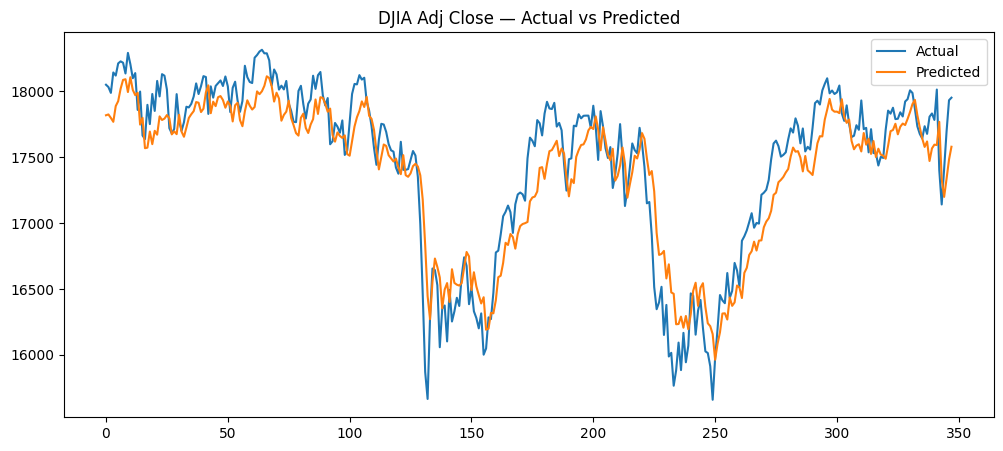

MSE: 61903.5057
RMSE: 248.8042
MAE: 200.3146
R² Score: 0.8529
MAPE: 1.16%


In [ ]:
# ============================================
# ✅ PLOT — Actual vs Predicted
# ============================================
plt.figure(figsize=(12,5))
plt.plot(y_test_inv, label='Actual')
plt.plot(y_pred_inv, label='Predicted')
plt.legend()
plt.title('DJIA Adj Close — Actual vs Predicted')
plt.show()
# ============================================
# ✅ METRICS
# ============================================
mse = mean_squared_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_inv, y_pred_inv)
r2 = r2_score(y_test_inv, y_pred_inv)
mape = mean_absolute_percentage_error(y_test_inv, y_pred_inv) * 100

print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R² Score: {r2:.4f}")
print(f"MAPE: {mape:.2f}%")


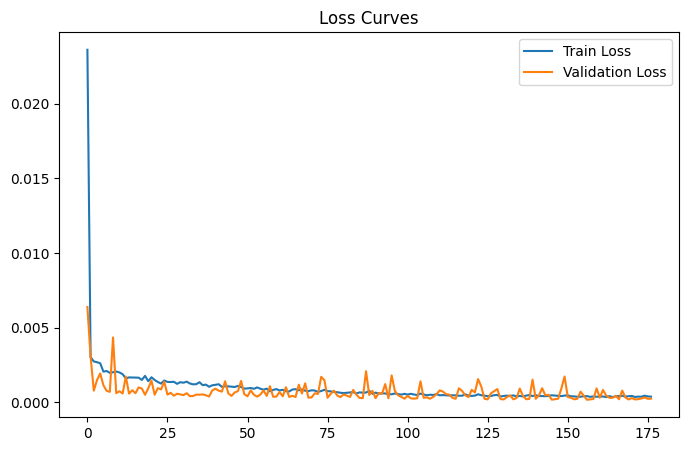

In [ ]:
# ============================================
# ✅ PLOT — Loss Curves
# ============================================
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss Curves')
plt.show()


In [ ]:
# ============================================
# ✅ TRAIN & TEST R² (correct)
# ============================================
train_preds_scaled = model.predict(X_train_seq)
train_pred_inv = y_scaler.inverse_transform(train_preds_scaled)
train_true_inv = y_scaler.inverse_transform(y_train_seq)

test_pred_scaled = model.predict(X_test_seq)
test_pred_inv = y_scaler.inverse_transform(test_pred_scaled)
test_true_inv = y_scaler.inverse_transform(y_test_seq)

print("✅ Train R²:", r2_score(train_true_inv, train_pred_inv))
print("✅ Test  R²:",  r2_score(test_true_inv,  test_pred_inv))


49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
✅ Train R²: 0.9976354380664271
✅ Test  R²: 0.8528808012603672
